In [5]:
import os
import numpy
from matplotlib import pyplot
from numpy.random import default_rng
from scipy.stats import wasserstein_distance
import matplotlib
import matplotlib.pyplot as plt
import Bio
import Bio.SeqRecord
import Bio.SeqIO
import pygtrie
import re
from IPython.core.display import display, HTML


def get_subfragment_indices_by_length(fragment, subfragment_min_length):
    while True:
        fragment_indices_count = fragment.shape[0]
        start_index = numpy.random.randint(fragment_indices_count)
        for end_index in range(start_index, fragment_indices_count):
            if fragment[end_index] - fragment[start_index] > subfragment_min_length:
                indices = numpy.array(list(range(start_index, end_index+1)))
                return indices


def get_subfragment_indices_by_count(fragment, subfragment_indices_count):
    while True:
        fragment_indices_count = fragment.shape[0]
        start_index = numpy.random.randint(fragment_indices_count)
        end_index = start_index + subfragment_indices_count - 1
        if end_index < fragment_indices_count:
            indices = numpy.array(list(range(start_index, end_index + 1)))
            return indices


def match_fragments(full_fragment, partial_fragment):
    normalized_partial_fragment = partial_fragment - partial_fragment[0]
    full_fragment_length = numpy.max(full_fragment)
    partial_fragment_length = numpy.max(normalized_partial_fragment)
    start_pos = 0
    end_pos = partial_fragment_length
    delta = 0.0000001
    max_dist = numpy.inf
    matched_indices = None
    x = []
    y = []
    while end_pos < 1:
        # indices = numpy.where(numpy.any((full_fragment > start_pos) and (full_fragment < end_pos)))
        # indices = numpy.where(numpy.any(full_fragment > start_pos))
        index_predicates = (full_fragment > start_pos) & (full_fragment < end_pos)
        indices = numpy.where(index_predicates)[0]
        indices.sort()

        current_fragment = full_fragment[indices]
        if current_fragment.shape[0] > 0:
            current_fragment = current_fragment - current_fragment[0]
            dist = wasserstein_distance(current_fragment, normalized_partial_fragment)
            x.append(start_pos)
            y.append(dist)
            if dist < max_dist:
                max_dist = dist
                matched_indices = indices

        end_pos = end_pos + delta
        start_pos = start_pos + delta

    return matched_indices, numpy.array(x), numpy.array(y)


def dye_chromosome(chromosome: Bio.SeqRecord.SeqRecord, fluorochrome: str):
    chromosome = chromosome.lower()
    fluorochrome = fluorochrome.lower()
    chromosome_str = str(chromosome.seq)
    indices = [m.start() for m in re.finditer(fluorochrome, chromosome_str)]
    fragment = numpy.array(indices).astype(float) / float(len(chromosome_str))
    return indices, fragment


def plot_fragment(fragment, color, markersize=4):
    y = numpy.zeros_like(fragment)
    x = fragment
    plt.plot(x, y, 'o', markersize=markersize, markerfacecolor=color, markeredgecolor=color)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)


def plot_fragments(full_fragment, partial_fragment, sampled_partial_fragment, transformed_sampled_partial_fragment, transformed_noised_sampled_partial_fragment, matched_fragment, x_dist, y_dist):
    figsize=(60, 5)
    fontsize = 20
    plt.figure(figsize=figsize)
    plot_fragment(fragment=full_fragment, color='blue')
    plot_fragment(fragment=partial_fragment, color='red')
    plt.xlim(0, 1)
    plt.title("Full Sequence and Partial Sequence", fontsize=fontsize)
    plt.show()

    # y3 = numpy.zeros_like(sampled_partial_fragment)
    # x3 = sampled_partial_fragment
    # plt.plot(x3, y3, 'o', markersize=2, markerfacecolor='green', markeredgecolor='green')


    plt.figure(figsize=figsize)
    plot_fragment(fragment=sampled_partial_fragment, color='green')
    plt.xlim(0, 1)
    plt.title("Sampled Partial Sequence", fontsize=fontsize)
    plt.show()

    plt.figure(figsize=figsize)
    plot_fragment(fragment=transformed_sampled_partial_fragment, color='magenta')
    plt.xlim(0, 1)
    plt.title("Sampled and Scaled Partial Sequence", fontsize=fontsize)
    plt.show()

    plt.figure(figsize=figsize)
    plot_fragment(fragment=transformed_noised_sampled_partial_fragment, color='orange')
    plt.xlim(0, 1)
    plt.title("Sampled, Scaled and Noised Partial Sequence", fontsize=fontsize)
    plt.show()

    plt.figure(figsize=figsize)
    plot_fragment(fragment=matched_fragment, color='purple')
    plt.xlim(0, 1)
    plt.show()

    plt.figure(figsize=figsize)
    plt.plot(x_dist, y_dist, '-', markersize=2)
    plt.xlim(0, 1)
    plt.title("Matched Sequence", fontsize=fontsize)
    plt.show()

C:\Users\roy.ve\AppData\Local\Temp\ipykernel_19160\450827228.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [6]:
    filename = os.path.normpath("C:/dna/GCA_000001405.29_GRCh38.p14_genomic.fna")
    seq_dict = {rec.id: rec for rec in Bio.SeqIO.parse(filename, "fasta")}
    chromosome4 = seq_dict['CM000666.2']
    # chromosome4_segment = chromosome4[88227200:88704008]
    chromosome4_segment = chromosome4
    chromosome4_segment_len = len(chromosome4_segment.seq)
    print(f'chromosome4_segment length: {chromosome4_segment_len}')
    full_fragment_indices, full_fragment = dye_chromosome(chromosome=chromosome4_segment, fluorochrome='CTTAAG')

chromosome4_segment length: 190214555


len(partial_fragment_indices): 16
noise: [-1.49152797e-07 -2.19167660e-07 -1.65745363e-07 -1.07069117e-07
  5.99330301e-07 -8.06366587e-08 -3.51527400e-08  3.47319411e-07
 -4.67143023e-07  1.38515761e-07 -4.89404181e-07  2.34070129e-07
 -1.66544599e-07 -1.24784776e-07  6.10275278e-08 -1.94525454e-07]
noise (bases): [-28.37103292 -41.68887896 -31.52718041 -20.36610451 114.00134656
 -15.33826615  -6.68656279  66.06520722 -88.85740232  26.34771389
 -93.09179852  44.52354549 -31.67920677 -23.73588066  11.60832404
 -37.00157276]
full fragment length: 45312
partial fragment length: 16
matched indices: [12072 12073 12074 12075 12076 12077 12078 12079 12080 12081 12082 12083
 12084 12085 12086 12087]
partial fragment indices: [36576 36577 36578 36579 36580 36581 36582 36583 36584 36585 36586 36587
 36588 36589 36590 36591]
matching_ratio: 0.0


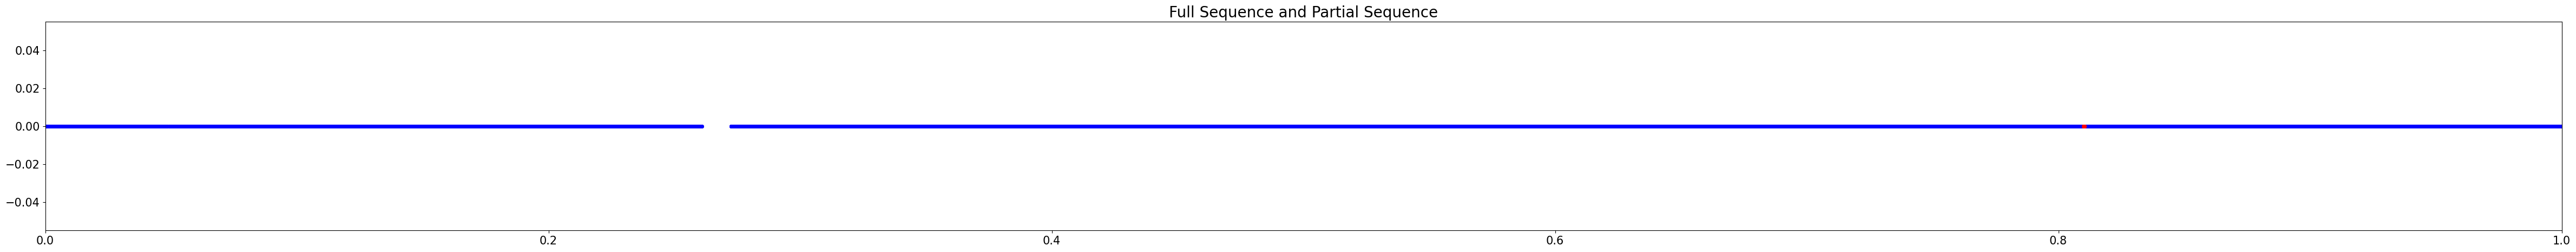

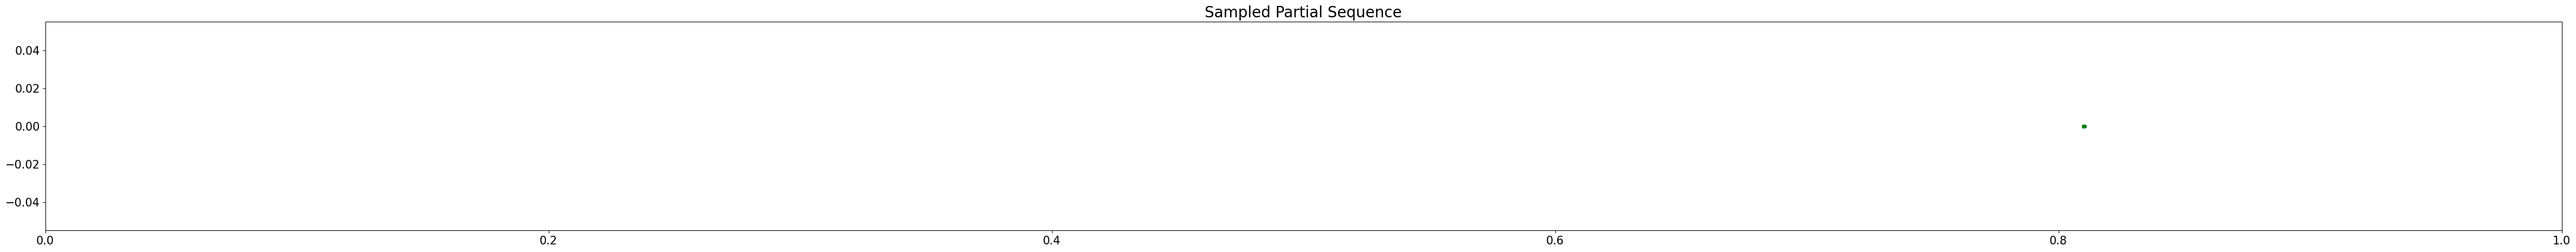

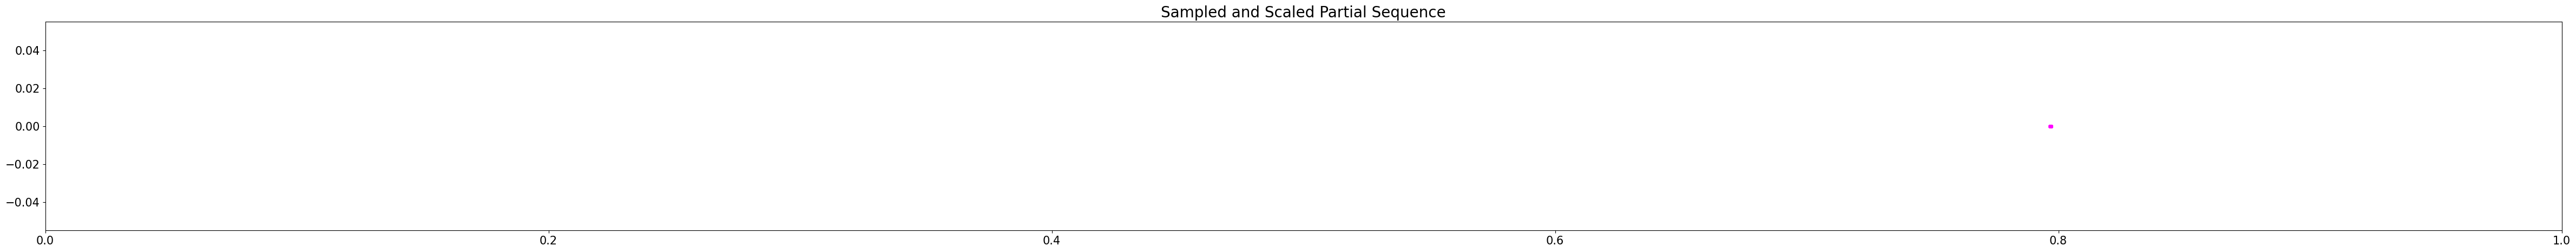

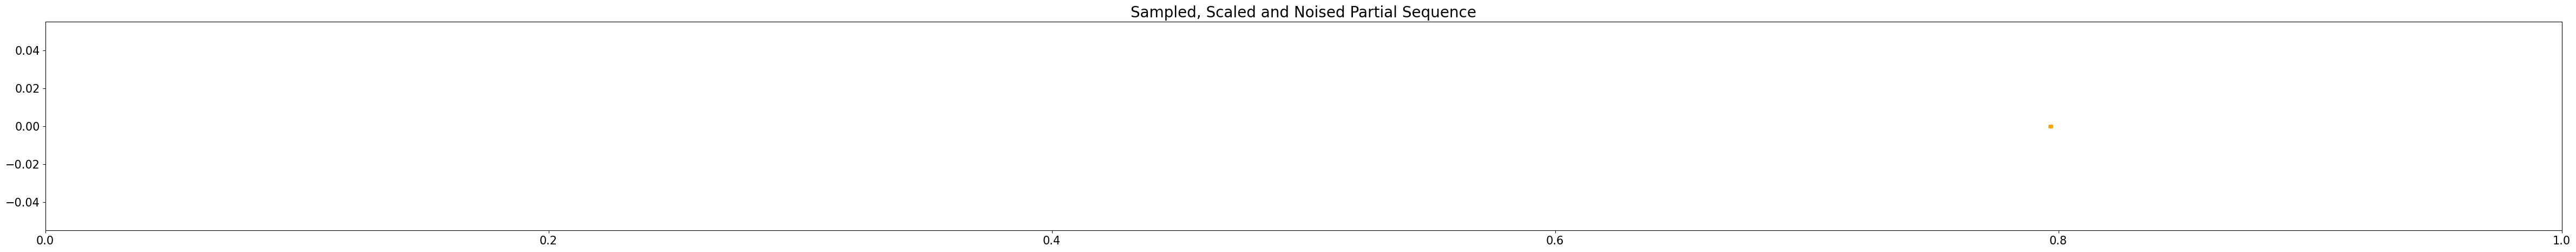

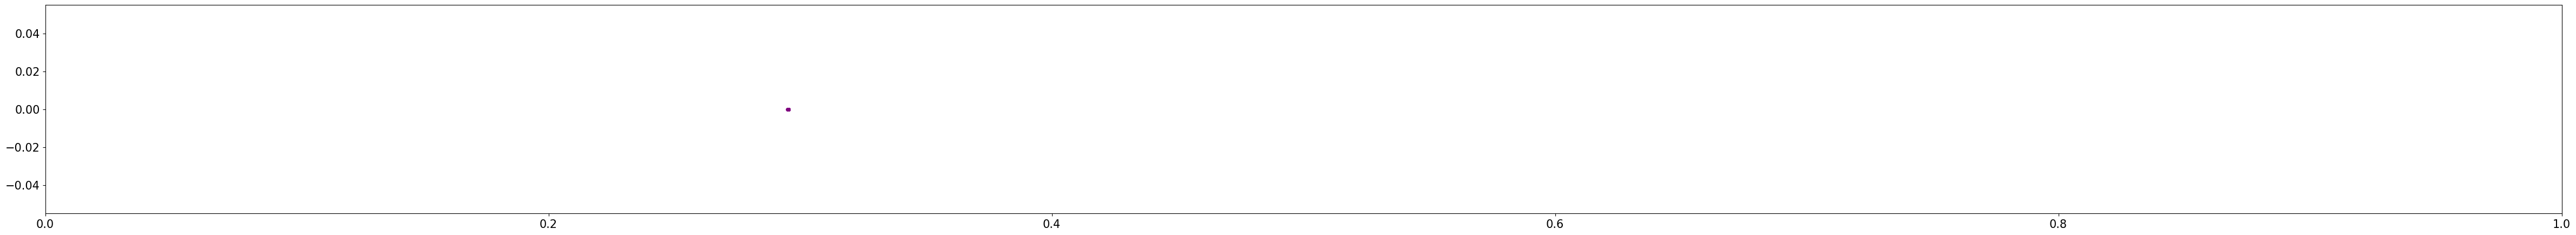

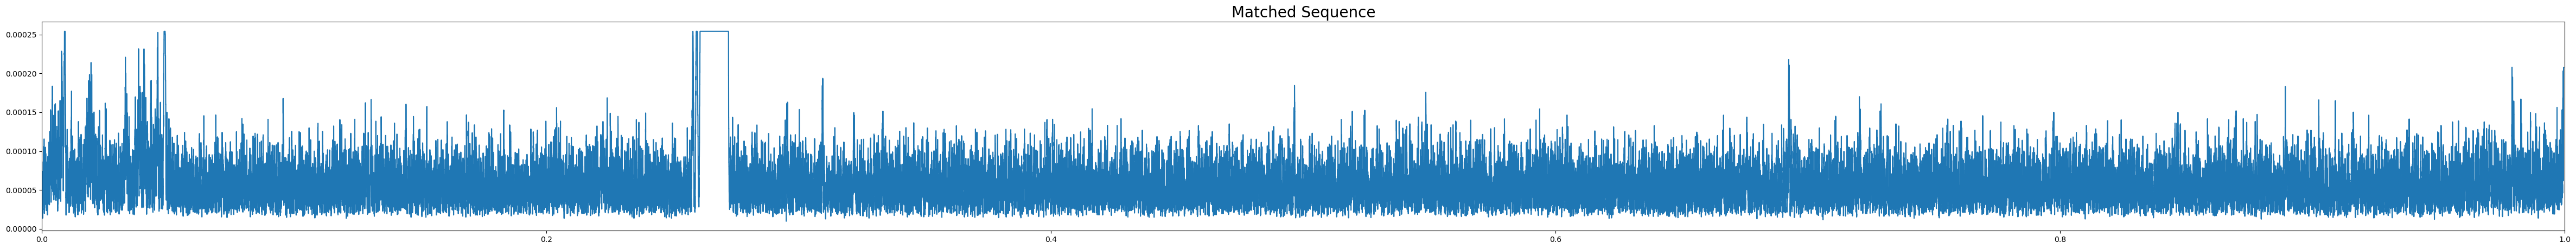

len(partial_fragment_indices): 16
noise: [-1.63170553e-07  2.14642966e-07  8.47131872e-08  4.39525390e-08
 -3.75061138e-07  1.10878490e-07  1.02045197e-07  8.70591380e-08
  6.74736386e-08 -3.54790780e-07 -1.49498906e-07  1.90260333e-07
 -2.27077015e-07 -6.39120163e-07 -3.25850200e-07  6.43255743e-08]
noise (bases): [ -31.03741412   40.82821635   16.11368121    8.36041265  -71.34208751
   21.09070266   19.41048179   16.55991519   12.83446814  -67.48637027
  -28.43686793   36.19028465  -43.19335339 -121.56995737  -61.98145077
   12.23566048]
full fragment length: 45312
partial fragment length: 16
matched indices: [32177 32178 32179 32180 32181 32182 32183 32184 32185 32186 32187 32188
 32189 32190 32191 32192]
partial fragment indices: [32177 32178 32179 32180 32181 32182 32183 32184 32185 32186 32187 32188
 32189 32190 32191 32192]
matching_ratio: 1.0


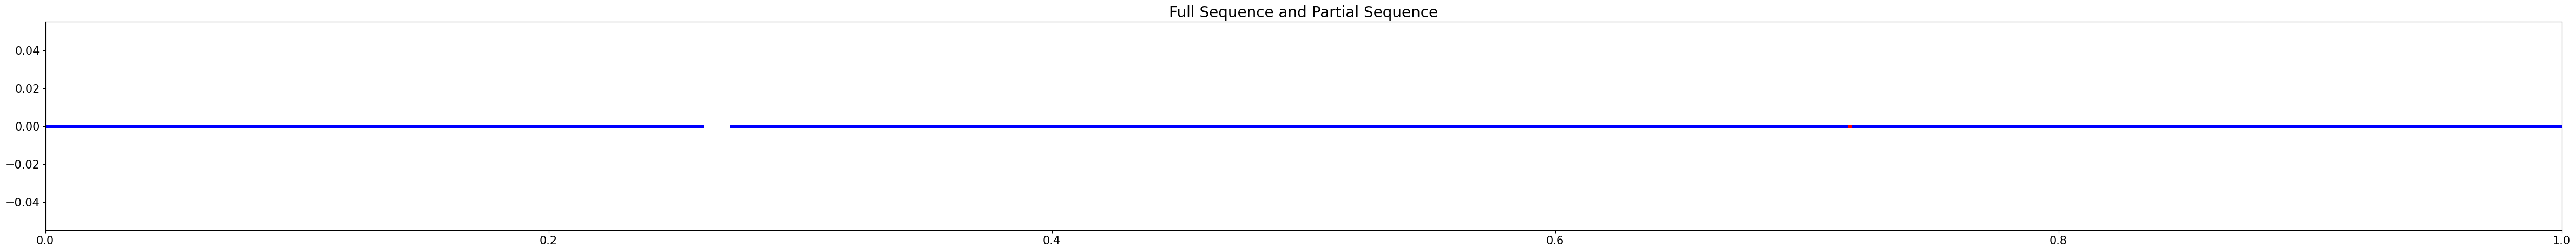

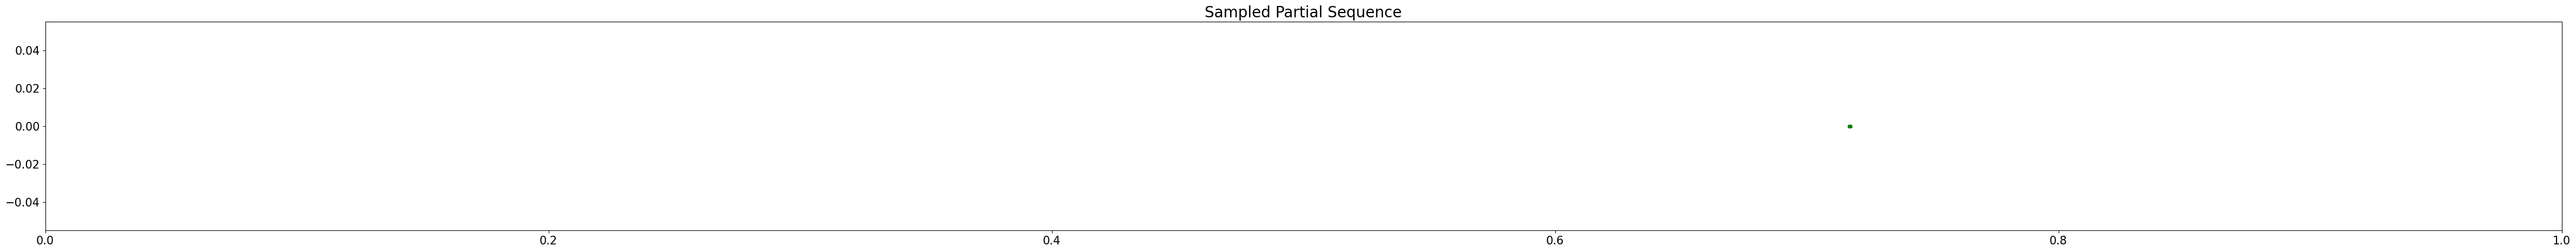

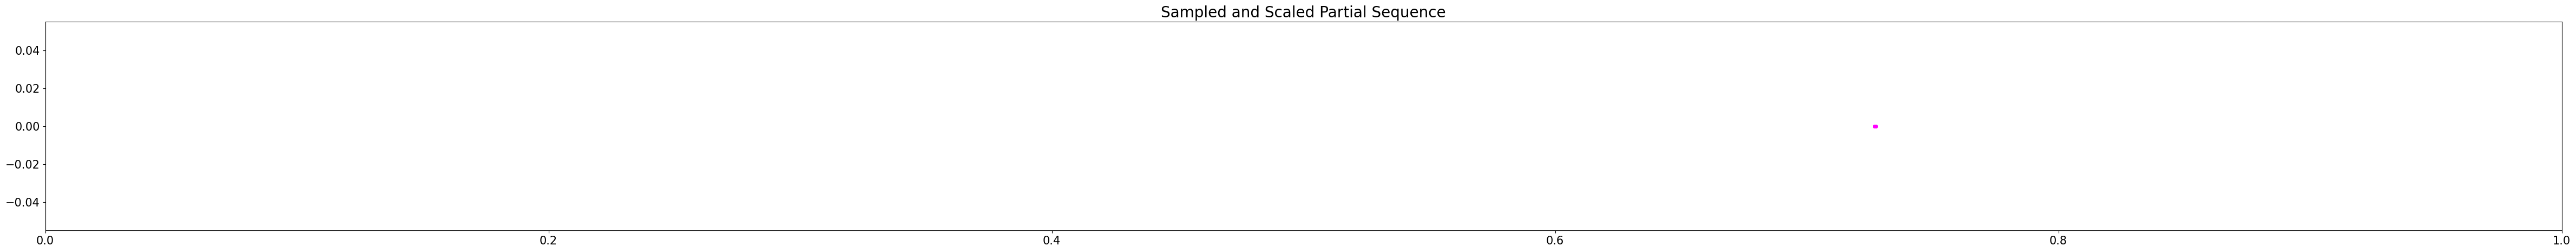

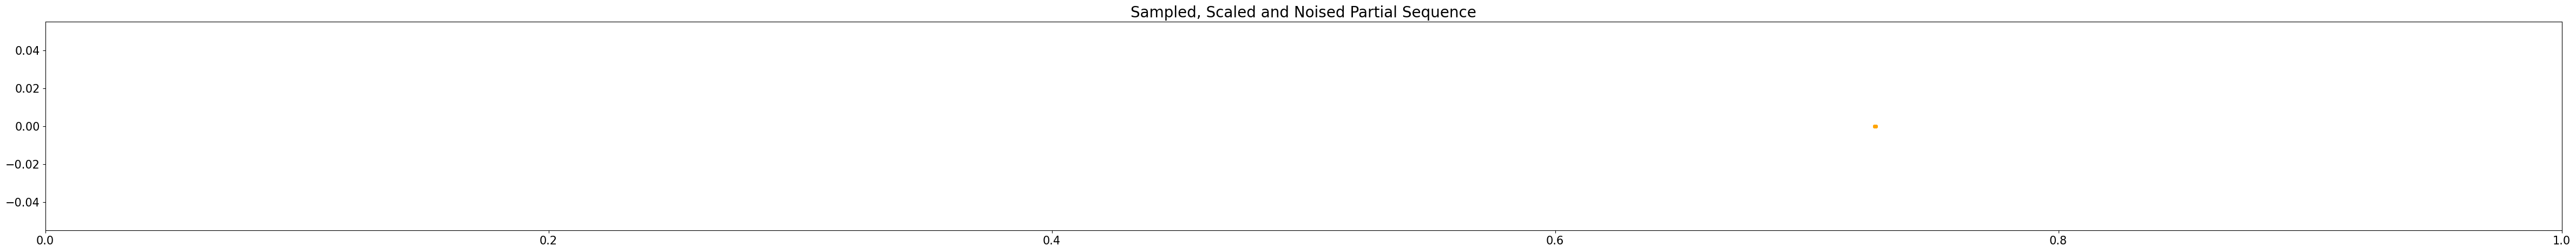

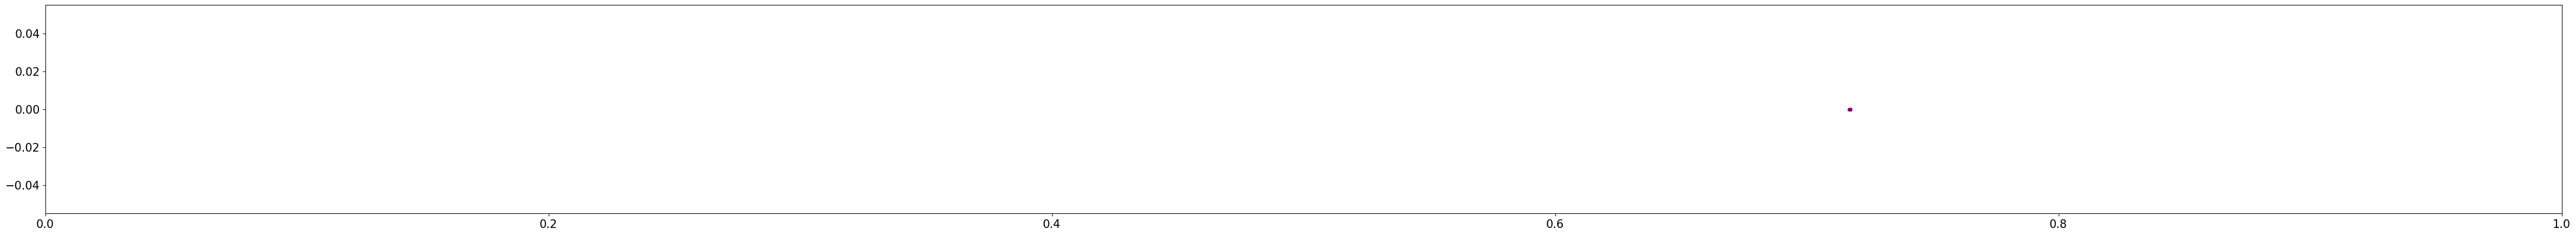

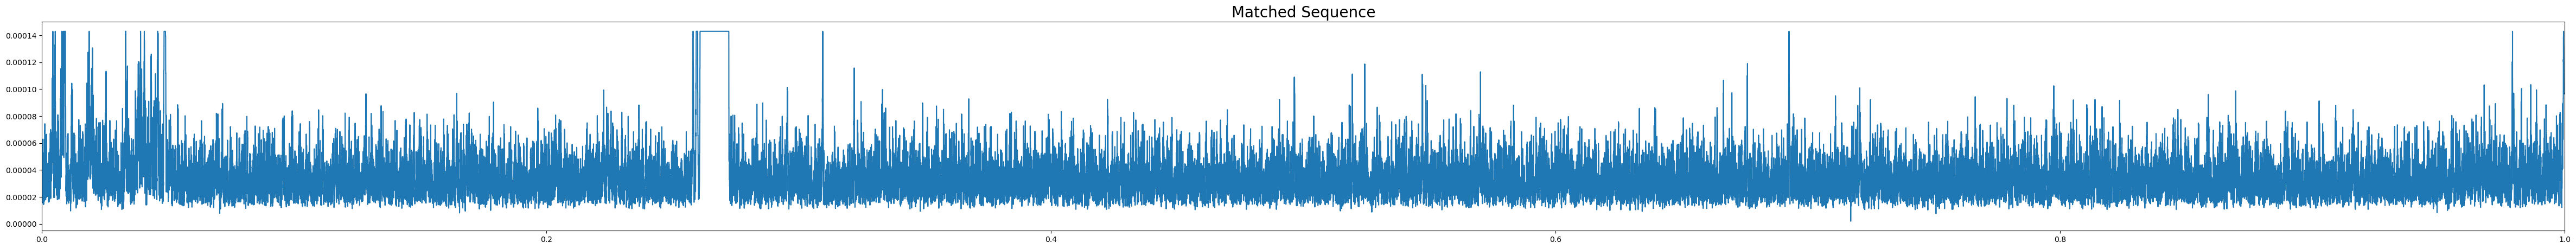

len(partial_fragment_indices): 16
noise: [ 2.98255956e-07  2.85522031e-07 -2.74762803e-08 -1.82841146e-07
  1.72350067e-07  3.64573105e-07  2.01576344e-07 -1.14871657e-07
 -4.20478652e-08 -4.66784547e-08  2.62763415e-07 -3.36617561e-07
  3.66181171e-07 -3.46274090e-08 -1.73888596e-07 -1.03451522e-07]
noise (bases): [ 56.73262392  54.31044607  -5.22638843 -34.77904721  32.78349125
  69.34711088  38.34275454 -21.85026112  -7.99811597  -8.87892148
  49.98142606 -64.02955955  69.65298853  -6.58663719 -33.076142
 -19.67798516]
full fragment length: 45312
partial fragment length: 16


KeyboardInterrupt: 

In [7]:
    # partial_fragment_indices = get_subfragment_indices_by_length(fragment=full_fragment, subfragment_min_length=0.1)
    experiments_count = 10
    for i in range(experiments_count):
        display(HTML(f'<h1>========= Experiment {i} =========</h1>'))
        # print(f'========= Experiment {i} =========')

        partial_fragment_indices = get_subfragment_indices_by_count(fragment=full_fragment, subfragment_indices_count=16)
        print(f'len(partial_fragment_indices): {len(partial_fragment_indices)}')
        partial_fragment = full_fragment[partial_fragment_indices]

        sampling_factor = 1
        # sampled_partial_fragment_size = int(partial_fragment_indices.shape[0] * sampling_factor)
        sampled_partial_fragment_size = 16
        # sampled_partial_fragment_meta_indices = numpy.random.choice(partial_fragment_indices.shape[0], sampled_partial_fragment_size, replace=False)
        # sampled_partial_fragment_meta_indices.sort()

        # sampled_partial_fragment_indices = partial_fragment_indices[sampled_partial_fragment_meta_indices]
        sampled_partial_fragment_indices = partial_fragment_indices[:sampled_partial_fragment_size]
        sampled_partial_fragment = full_fragment[sampled_partial_fragment_indices]
        sampled_partial_fragment.sort()

        min_scale = 0.95
        max_scale = 1.05
        scale = (max_scale - min_scale) * numpy.random.random(1) + min_scale

        mu, sigma = 0, 50
        # transformed_sampled_partial_fragment = scale * (sampled_partial_fragment - sampled_partial_fragment[0])
        transformed_sampled_partial_fragment = scale * sampled_partial_fragment
        # transformed_sampled_partial_fragment = transformed_sampled_partial_fragment - transformed_sampled_partial_fragment[0]
        noise = numpy.random.normal(mu, sigma, transformed_sampled_partial_fragment.shape[0])
        noise = noise / chromosome4_segment_len

        print(f'noise: {noise}')
        print(f'noise (bases): {noise * chromosome4_segment_len}')

        # transformed_noised_sampled_partial_fragment = transformed_sampled_partial_fragment + noise
        transformed_noised_sampled_partial_fragment = transformed_sampled_partial_fragment
        # transformed_noised_sampled_partial_fragment = transformed_noised_sampled_partial_fragment - transformed_noised_sampled_partial_fragment[0]

        print(f'full fragment length: {full_fragment.shape[0]}')
        print(f'partial fragment length: {transformed_sampled_partial_fragment.shape[0]}')

        matched_indices, x_dist, y_dist = match_fragments(full_fragment=full_fragment, partial_fragment=transformed_noised_sampled_partial_fragment)
        matched_fragment = full_fragment[matched_indices]

        print(f'matched indices: {matched_indices}')
        print(f'partial fragment indices: {partial_fragment_indices}')

        indices_diff = len(list(set(partial_fragment_indices) - set(matched_indices)))
        indices_count = len(list(partial_fragment_indices))
        if indices_diff > indices_count:
            print(f'matching_ratio: FAILED')
        else:
            matching_ratio = 1 - (indices_diff / indices_count)
            print(f'matching_ratio: {matching_ratio}')

        plot_fragments(
            full_fragment=full_fragment,
            partial_fragment=partial_fragment,
            sampled_partial_fragment=sampled_partial_fragment,
            transformed_sampled_partial_fragment=transformed_sampled_partial_fragment,
            transformed_noised_sampled_partial_fragment=transformed_noised_sampled_partial_fragment,
            matched_fragment=matched_fragment,
            x_dist=x_dist,
            y_dist=y_dist)